<a href="https://colab.research.google.com/github/baraa-hakawati/Prediction-of-Product-Sales/blob/main/LogReg%2C_Random_Forest%2C_or_KNN_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report   # New!
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Dataset Discovery

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
# Read in file from folder structure--this is the cleaned version (still has null values)
filename = '/content/drive/MyDrive/AXSOSACADEMY/02-MachineLearning/Week07/Data/stroke.csv'
stroke_df = pd.read_csv(filename)
stroke_df.info()
stroke_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1137 non-null   int64  
 1   gender             1137 non-null   object 
 2   age                1137 non-null   object 
 3   hypertension       1137 non-null   int64  
 4   heart_disease      1137 non-null   int64  
 5   ever_married       1137 non-null   object 
 6   work_type          1137 non-null   object 
 7   Residence_type     1137 non-null   object 
 8   avg_glucose_level  1137 non-null   float64
 9   bmi                1085 non-null   float64
 10  smoking_status     1137 non-null   object 
 11  stroke             1137 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 106.7+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1192,Female,31,0,0,No,Govt_job,Rural,70.66,27.2,never smoked,0
1,77,Female,13,0,0,No,children,Rural,85.81,18.6,Unknown,0
2,59200,Male,18,0,0,No,Private,Urban,60.56,33.0,never smoked,0
3,24905,Female,65,0,0,Yes,Private,Urban,205.77,46.0,formerly smoked,1
4,24257,Male,4,0,0,No,children,Rural,90.42,16.2,Unknown,0


In [4]:
stroke_df['stroke'].value_counts(normalize=True)

,proportion
stroke,
0,0.879507
1,0.120493


**The dataset we have is highly imbalanced ( 12% stroke cases).**

In [5]:
stroke_df.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,52


# Preprocessing

In [6]:
# Create features matrix and target vector
X = stroke_df.drop(columns = ['id', 'stroke'])
y = stroke_df['stroke']
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [7]:
ohe_cols = X_train.select_dtypes('object').columns
X_train[ohe_cols].isna().sum().sum()

np.int64(0)

In [8]:
print("OneHotEncoder Columns:", ohe_cols)
# Only one prcedure, no need for pipeline during the stage.
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_encoder, ohe_cols)
ohe_tuple

OneHotEncoder Columns: Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


('categorical',
 OneHotEncoder(handle_unknown='ignore', sparse_output=False),
 Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
        'smoking_status'],
       dtype='object'))

In [9]:
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


In [10]:
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                  verbose_feature_names_out=False)

# Logistic Regression Model

## Default Logistic Regression Model

In [11]:
# Default model
logreg = LogisticRegression()
# Make a pipeline to scale the data and fit a model
logreg_pipe = make_pipeline(preprocessor, logreg)
# Fit the model on the training data
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       749
           1       0.64      0.16      0.25       103

    accuracy                           0.89       852
   macro avg       0.77      0.57      0.59       852
weighted avg       0.86      0.89      0.86       852



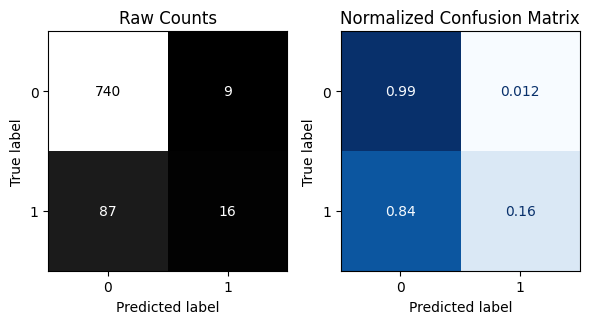


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       251
           1       0.33      0.06      0.10        34

    accuracy                           0.87       285
   macro avg       0.61      0.52      0.52       285
weighted avg       0.82      0.87      0.83       285



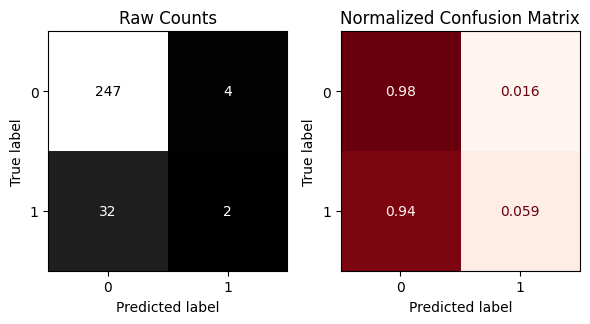

In [12]:
results = evaluate_classification(
    logreg_pipe, X_train, y_train, X_test, y_test,
    figsize=(6, 4), normalize='true', output_dict=True,
    cmap_train='Blues', cmap_test="Reds", colorbar=False
)

## Hyperparameter Tuning with GridSearchCV

In [13]:
# Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
               'logisticregression__penalty' : ['elasticnet'],
                'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                     'logisticregression__class_weight': [None, 'balanced']}
# Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000],
             'logisticregression__class_weight': [None, 'balanced']}
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000],
             'logisticregression__class_weight': [None, 'balanced']}
# Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
               'logisticregression__penalty' : [None]}
# Now make a list of the param dictionaries
param_grid = [l2_params, l1_params, elasticnet_params, none_params]

In [14]:
## Warning: this gridsearch may take 5-10 minutes to run!!
# Instantiate gridsearch
logreg_grid = GridSearchCV(logreg_pipe, param_grid, cv=3, verbose = 5, n_jobs = -1,
                  scoring='recall_macro')
# Fit the gs on the training data only
logreg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 155 candidates, totalling 465 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sp...
                         {'logisticregression__class_weight': [None,
                                                               'balanced'],
                          'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3,
                                                           0.4, 0.5, 0.6, 0.7,
                                                           0.8, 0.9, 1],
                          'logisticregression__penalty': ['elasticnet'],
                          'logisticregression__solver': ['saga']},
                         {'logisticregression__penalty': [None],
                          'logisticregression__solver': ['lbfgs', 'newton-cg',
                                                         'newton-cholesky',
                                                         'sag', 'saga']}],
             scoring='recall_macro', verbose=5)

In [15]:
# Best parameters
print("Best Parameters:", logreg_grid.best_params_)

Best Parameters: {'logisticregression__class_weight': 'balanced', 'logisticregression__l1_ratio': 0.5, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       749
           1       0.33      0.83      0.47       103

    accuracy                           0.78       852
   macro avg       0.65      0.80      0.67       852
weighted avg       0.89      0.78      0.81       852



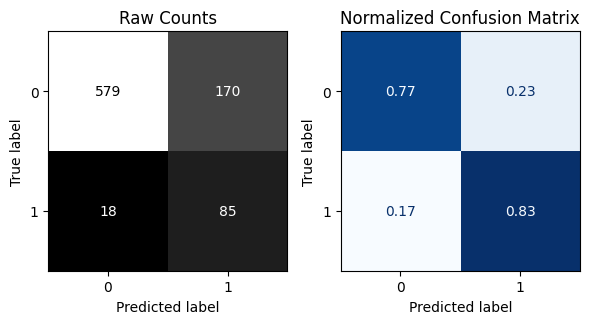


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       251
           1       0.25      0.59      0.35        34

    accuracy                           0.74       285
   macro avg       0.59      0.67      0.59       285
weighted avg       0.85      0.74      0.78       285



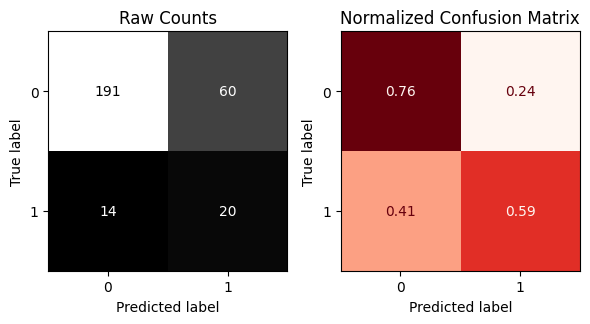

In [16]:
# Evalaute the best model
best_logreg = logreg_grid.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)

## Overall Evaluation

- **Default Model:**
  - Macro Recall: 0.52
  - Recall (class 1): 0.06
- **Tuned Model:**
  - Macro Recall: 0.67
  - Recall (class 1): 0.59
-**Note:** Some drop in accuracy and recall for class 0 — but major improvement in identifying strokes (class 1).

# K-Nearest Neighbors (KNN)

## Default KNN Model

In [ ]:
# Default model
knn = KNeighborsClassifier()
# Make a pipeline to scale the data and fit a model
knn_pipe = make_pipeline(preprocessor, knn)
# Fit the model on the training data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       749
           1       0.64      0.20      0.31       103

    accuracy                           0.89       852
   macro avg       0.77      0.59      0.62       852
weighted avg       0.87      0.89      0.86       852



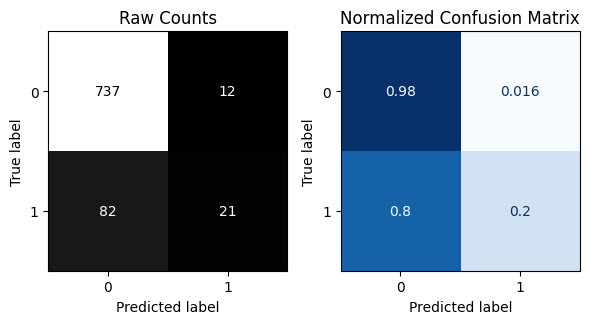


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       251
           1       0.17      0.03      0.05        34

    accuracy                           0.87       285
   macro avg       0.52      0.50      0.49       285
weighted avg       0.80      0.87      0.82       285



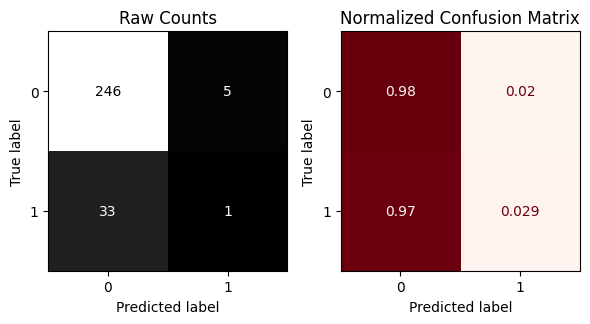

In [ ]:
results = evaluate_classification(
    knn_pipe, X_train, y_train, X_test, y_test,
    figsize=(6, 4), normalize='true', output_dict=True,
    cmap_train='Blues', cmap_test="Reds", colorbar=False
)

## Hyperparameter Tuning with GridSearchCV

In [ ]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

In [ ]:
knn_grid = GridSearchCV(knn_pipe, param_grid, scoring='recall_macro',
                        cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sp...
                                                                         Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='recall_macro')

In [ ]:
# Best parameters
print("Best Parameters:", knn_grid.best_params_)

Best Parameters: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       749
           1       0.64      0.14      0.22       103

    accuracy                           0.89       852
   macro avg       0.76      0.56      0.58       852
weighted avg       0.86      0.89      0.85       852



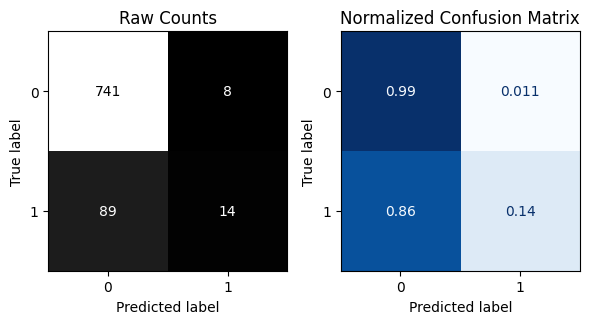


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       251
           1       0.00      0.00      0.00        34

    accuracy                           0.87       285
   macro avg       0.44      0.49      0.47       285
weighted avg       0.77      0.87      0.82       285



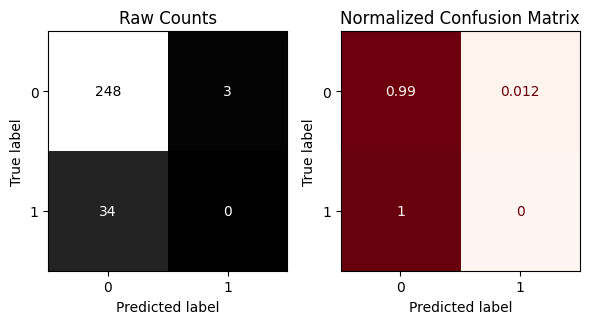

In [ ]:
# Evalaute the best model
best_knn = knn_grid.best_estimator_
evaluate_classification(best_knn, X_train, y_train, X_test, y_test)

## Overall Evaluation

- **Default Model:**
  - Macro Recall: 0.50
  - Recall (class 1): 0.03
- **Tuned Modle:**
  - Macro Recall: 0.49
  - Recall (class 1): 0.00
- **Note:** Failed to improve minority class recall, making it ineffective for this task.

# Random Forest

## Default Random Forest

In [ ]:
# Default model
rf = RandomForestClassifier(random_state=42)
# Make a pipeline to scale the data and fit a model
rf_pipe = make_pipeline(preprocessor, rf)
# Fit the model on the training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['gender', 'age', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       103

    accuracy                           1.00       852
   macro avg       1.00      1.00      1.00       852
weighted avg       1.00      1.00      1.00       852



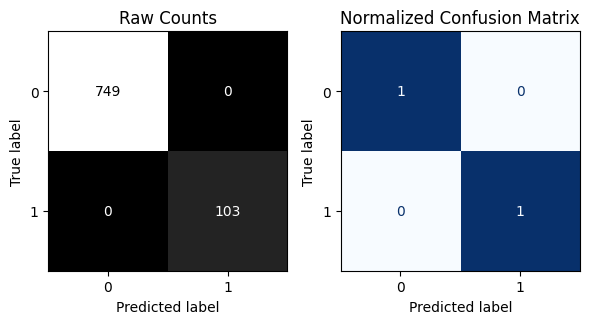


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       251
           1       0.00      0.00      0.00        34

    accuracy                           0.87       285
   macro avg       0.44      0.49      0.47       285
weighted avg       0.77      0.87      0.82       285



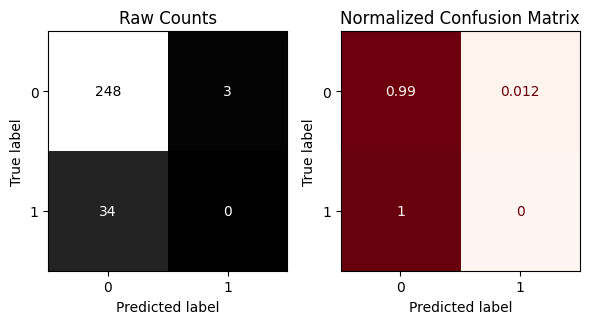

In [ ]:
results = evaluate_classification(
    rf_pipe, X_train, y_train, X_test, y_test,
    figsize=(6, 4), normalize='true', output_dict=True,
    cmap_train='Blues', cmap_test="Reds", colorbar=False
)

## Hyperparameter Tuning with GridSearchCV

In [ ]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 5, 10],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [ ]:
rf_grid = GridSearchCV(rf_pipe,param_grid, scoring='recall_macro',
                       cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sp...
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': [None,
                                                                  'balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__max_depth': [None, 5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5],
                         'randomforestclassifier__n_estimators': [100, 200]},
             scoring='recall_macro')

In [ ]:
# Best parameters
print("Best Parameters:", rf_grid.best_params_)

Best Parameters: {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       749
           1       0.39      0.81      0.53       103

    accuracy                           0.83       852
   macro avg       0.68      0.82      0.71       852
weighted avg       0.90      0.83      0.85       852



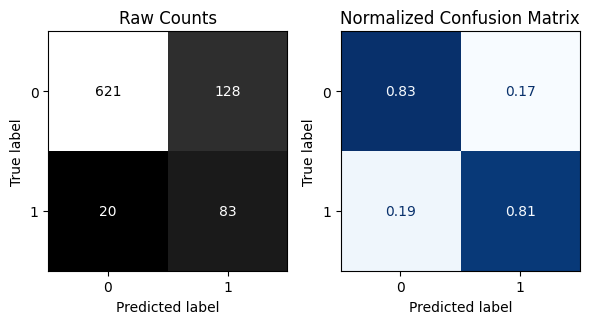


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       251
           1       0.22      0.41      0.29        34

    accuracy                           0.76       285
   macro avg       0.57      0.61      0.57       285
weighted avg       0.83      0.76      0.79       285



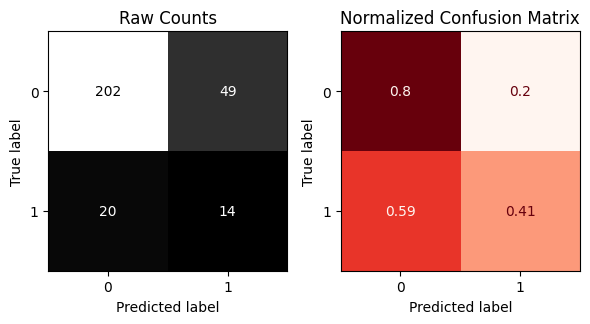

In [ ]:
# Evalaute the best model
best_rf = rf_grid.best_estimator_
evaluate_classification(best_rf, X_train, y_train, X_test, y_test)

## Overall Evaluation

- **Default Model:**
  - Macro Recall: 0.49
  - Recall (class 1): 0.00
- **Tuned Mpdel:**
  - Macro Recall: 0.61
  - Recall (class 1): 0.41
- **Note:** Significant improvement, but still worse than tuned Logistic Regression on key metric.

# Recommended Model for Production

- **Preferred Model:**
  - Tuned Logistic Regression
- **Justifications:**
  - Highest macro recall (0.67), outperforming all others.
  - Recall for minority class (stroke) is 0.59, nearly 10x improvement over default and significantly better than all others.
  - Though accuracy and precision for class 0 drop slightly, the goal here is to catch more stroke cases, making this trade-off acceptable.
  - Logistic regression is also easier to interpret and deploy than more complex models.